In [1]:
#import libraries
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud
import itertools  
from textblob import TextBlob 

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [15]:
#Define all functions
def findmention(tweet):
    words=tweet.split()
    mention=[]
    for i in words:
        if i.startswith("@"):
            mention.append(i)
    return mention
def findhashtag(tweet):
    words=tweet.split()
    hashtag=[]
    for i in words:
        if i.startswith("#"):
            hashtag.append(i)
    return hashtag
def getmaxhashtags(df):
    hashtags={}
    for i in range(df.shape[0]):
        for j in df["Hashtag"][i]:
            if j not in hashtags.keys():
                hashtags[j]=1
            else:
                hashtags[j]=hashtags[j]+1
    a=dict(sorted(hashtags.items(), key=lambda item: item[1],reverse=True))
    out = dict(itertools.islice(a.items(), 5))  
    return out
def getmaxmention(df):
    mention={}
    for i in range(df.shape[0]):
        for j in df["mention"][i]:
            if j not in mention.keys():
                mention[j]=1
            else:
                mention[j]=mention[j]+1
    a=dict(sorted(mention.items(), key=lambda item: item[1],reverse=True))
    out = dict(itertools.islice(a.items(), 5))  
    return out
def getdate(time):
    return time.split("T")[0]

def getmonth(dat):
    return str(dat[1])+"-"+str(dat[0])
def avgandmaxtweets(df):
    df["Date"]=df["Time"].apply(getdate)
    df["Date"]=df["Date"].astype('datetime64[ns]')
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['month'] = pd.DatetimeIndex(df['Date']).month
    temp=df.groupby(["year","month"]).count()["Text"].to_frame()
    temp["Month+Year"]=temp.index
    avg_tweets=temp.mean()["Text"]
    Maxmonth=temp[temp["Text"]==temp.max()["Text"]]["Month+Year"]
    return avg_tweets,Maxmonth
def givestats(df):
    avglikes=df.mean()["likeCount"]
    avgcomment=df.mean()["commentCount"]
    avgretweet=df.mean()["retweetCount"]
    maxlike=df.max()["likeCount"]
    maxcomment=df.max()["commentCount"]
    maxretweet=df.max()["retweetCount"]
    return avglikes,avgcomment,avgretweet,maxlike,maxcomment,maxretweet
                
#Preprocessing
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

#defining the function to preprocess the data
def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()
def get_tweet_sentiment(df):
    positive=0
    negative=0
    neutral=0
    total=0
    weakPositive=0
    weakNegative=0
    strongPositive=0
    strongNegative=0
    for i in df["cleanText"]:
        total=total+1
        analysis = TextBlob(i)
        polarity=analysis.sentiment.polarity
        if (polarity == 0):
            neutral=neutral+1
        elif (polarity > 0 and polarity <= 0.3):
            weakPositive=weakPositive+1
        elif (polarity > 0.3 and polarity <= 0.6):
            positive=positive+1
        elif (polarity > 0.6 and polarity <= 1):
            strongPositive=strongPositive+1
        elif (polarity > -0.3 and polarity <= 0):
            weakNegative=weakNegative+1
        elif (polarity > -0.6 and polarity <= -0.3):
            negative=negative+1
        elif (polarity > -1 and polarity <= -0.6):
            strongNegative=strongNegative+1
    positive=int(positive/total*100)
    negative=int(negative/total*100)
    neutral=int(neutral/total*100)
    weakPositive=int(weakPositive/total*100)
    weakNegative=int(weakNegative/total*100)
    strongPositive=int(strongPositive/total*100)
    strongNegative=int(strongNegative/total*100)
    plt.style.use('dark_background')
    lab = 'Neutral', 'WeakPositive', 'Positive', 'StrongPositive','WeakNegative','Negative','StrongNegative'
    labels=['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(weakPositive) + '%]','Strongly Positive [' + str(strongPositive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(weakNegative) + '%]', 'Strongly Negative [' + str(strongNegative) + '%]']
    sizes = [positive, weakPositive, strongPositive, neutral, negative, weakNegative, strongNegative]
    colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
    patches, texts = plt.pie(sizes,colors=colors,labels = lab, shadow = True,startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('EY_Assurance.png')
    plt.show()



In [16]:
#Just change the dataset and get sentiments about any company
df=pd.read_csv("Services/EY_Assurance.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
df.head()
getMaxHashtag=getmaxhashtags(df)
getMaxMention=getmaxmention(df)
avgTweet,maxMonth=avgandmaxtweets(df)
avglikes,avgcomment,avgretweet,maxlike,maxcomment,maxretweet=givestats(df)
#positive,neutral,negative=get_tweet_sentiment(df)

In [17]:
#print all values
print("Most Used Hashtags:"+str(getMaxHashtag))
print("Most common Mention:"+str(getMaxMention))
print("Average Tweets per month"+str(avgTweet))
print("Month with maximum tweets"+str(maxMonth))
print("Average like per post"+str(avglikes))
print("Average comment per post"+str(avgcomment))
print("Average Retweet per post"+str(avgretweet))
print("Maximum like on post"+str(maxlike))
print("Maximum comment on post"+str(maxcomment))
print("Maximum retweet on post"+str(maxretweet))


Most Used Hashtags:{'#EY': 35, '#apprenticeships': 15, '#Assurance': 14, '#BetterWorkingWorld': 13, '#assurance': 10}
Most common Mention:{'@EY_Africa': 14, '@EY_CareersUK': 12, '@EY_UKI': 8, '@RandallTavierne': 6, '@EY_US': 6}
Average Tweets per month16.217391304347824
Month with maximum tweetsyear  month
2019  1        (2019, 1)
      3        (2019, 3)
      4        (2019, 4)
      9        (2019, 9)
Name: Month+Year, dtype: object
Average like per post2.292225201072386
Average comment per post0.11796246648793565
Average Retweet per post1.0777479892761395
Maximum like on post56.0
Maximum comment on post12.0
Maximum retweet on post101.0


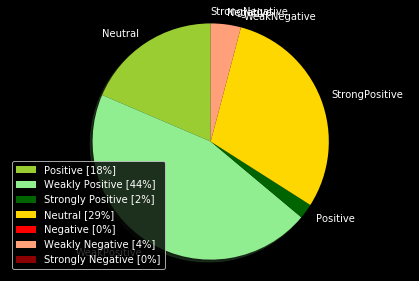

In [18]:
get_tweet_sentiment(df)